In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from garanapy import event
from garanapy import datamanager
from garanapy import plotting

In [2]:
data_path = "../data"

In [3]:
data_manager = datamanager.DataManager()
data_manager.open_events(data_path, n_files=-1)

Output()

In [5]:
# Save the loaded events for later
data_manager.save("loaded_events.pickle")

In [6]:
# Later is now!
with open("loaded_events.pickle", 'rb') as inp:
    data_manager = pickle.load(inp)

In [7]:
# Define two functions that extract information in an event-by-event basis
def a_function_per_event(event: event.Event, nu_pdg: int, cc: bool):
    # Select numu CC events using MC truth
    if (event.nu.type == nu_pdg)&(event.nu.cc == cc):
        return event.nu.energy
    else:
        return None

def another_function_per_event(event: event.Event, muon_cut: float):
    # Create list of reco particles with negative charge and muon score greater than cut
    candidates = [(p.id, p.momentum, p.muon_score) for p in event.recoparticle_list if (p.charge == -1) & (p.muon_score >= muon_cut)]
    # Sort candidate list by increasing momentum
    candidates = sorted(candidates, key=lambda x: x[1])

    if (len(candidates) > 0):
        # Primary muon identified, return true nu energy
        return event.nu.energy
    else:
        return None

In [9]:
# Define a binning
energy_bins = np.linspace(0.0, 8.0, 21)

# Using the functions we defined above, we need to create a Variable
# object with the desired function and arguments
a_variable = datamanager.Variable(a_function_per_event, 14, True)
# Then, we use that instance of the Variable class and our binning
# to create a spectrum (which is similar to a histogram)
a_spectrum = datamanager.Spectrum(a_variable, energy_bins)
# Finally, we add the Spectrum to our DataManager so it could
# be filled after
data_manager.add_spectrum(a_spectrum, "a_spectrum")

# Repeat same steps for any additional quantities
another_variable = datamanager.Variable(another_function_per_event, 0.5)
another_spectrum = datamanager.Spectrum(another_variable, energy_bins)
data_manager.add_spectrum(another_spectrum, "another_spectrum")

In [23]:
# This function is not properly type-hinted
# A KeyError will be raised when trying to create the Variable
def a_bad_function(event, nu_pdg, cc):
    if (event.nu.type == nu_pdg)&(event.nu.cc == cc):
        return event.nu.energy
    else:
        return None
    
a_bad_variable = datamanager.Variable(a_bad_function, 14, True)

KeyError: 'Input function for Variable object was not properly type hinted!'

In [24]:
# The first argument of this function is not of type Event
# A TypeError will be raised when trying to create the Variable
def another_bad_function(event: np.array, nu_pdg: int, cc: bool):
    if (event.nu.type == nu_pdg)&(event.nu.cc == cc):
        return event.nu.energy
    else:
        return None

another_bad_variable = datamanager.Variable(another_bad_function, 14, True)

TypeError: First argument in input function must be of type event.Event!

In [13]:
# Time to load all the spectra we added
data_manager.load_spectra()

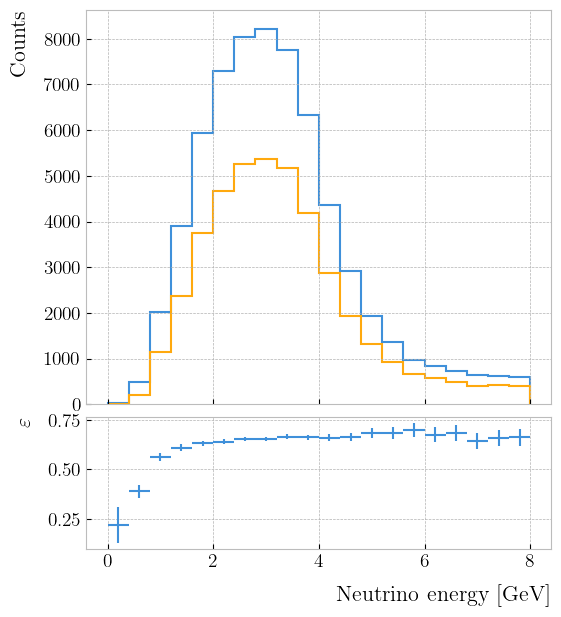

In [14]:
# Now we can plot the results

fig = plt.figure(figsize=(6,7))
gs = fig.add_gridspec(2, 1, hspace=0.05, height_ratios=[3,1])
axs = gs.subplots(sharex=True, sharey=False)

# Extract the histogram from the filled Spectrum
a_histogram = a_spectrum.hist
a_histogram.get_histogram(axs[0])

another_histogram = another_spectrum.hist
another_histogram.get_histogram(axs[0])

axs[0].set_ylabel("Counts", fontsize=16, labelpad=10, loc="top")
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].grid()

# We can use the histogram_ratio function to easily get another Histogram
# of the ratio (computes also the uncertainties)
ratio_histogram = plotting.histogram_ratio(another_histogram, a_histogram)
ratio_histogram.get_histogram_errorbar(axs[1])

axs[1].set_xlabel("Neutrino energy [GeV]", fontsize=16, labelpad=10, loc="right")
axs[1].set_ylabel(r"$\varepsilon$", fontsize=16, labelpad=10, loc="top")
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid()

plt.show()

In [19]:
# We can try a slightly different variable

def yet_another_function_per_event(event: event.Event, muon_cut: float, target: str):

    if target not in ["TP", "FP", "FN", "TN"]:
        raise(ValueError, f'Invalid target requested {target}')

    if (event.nu.type == 14) & (event.nu.cc == True):
        numu_cc = True
    else:
        numu_cc = False
        
    # Create list of reco particles with negative charge and muon score greater than cut
    candidates = [(p.id, p.momentum, p.muon_score) for p in event.recoparticle_list if (p.charge == -1) & (p.muon_score >= muon_cut)]
    # Sort candidate list by increasing momentum
    candidates = sorted(candidates, key=lambda x: x[1])

    if (len(candidates) > 0):
        # Get the muon candidate using the ID of the highest momentum
        # reco particle in candidate list
        muon_id = candidates[0][0]
        muon = event.get_recoparticle(muon_id)

        if (numu_cc == True):
            if (muon.mc_pdg == 13) & (muon.mc_primary == 1):
                result = "TP"
            else:
                result = "FP"
        else:
            result = "FP"

    else:
        if (numu_cc == True):
            result = "FN"
        else:
            result = "TN"

    if result == target:
        return muon.mc_momentum
    else:
        return None
    
momentum_bins = np.linspace(0.0, 3.0, 21)
yet_another_variable = datamanager.Variable(yet_another_function_per_event, 0.5, "FP")
yet_another_spectrum = datamanager.Spectrum(yet_another_variable, momentum_bins)

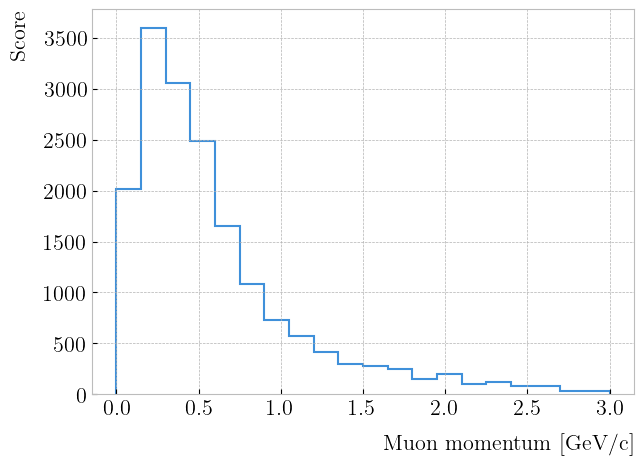

In [22]:
fig, ax = plt.subplots(figsize=(7,5))

# Here, instead of loading all the spectra again we can
# just load the new one we just created
data_manager.load_spectrum(yet_another_spectrum)
yet_another_histogram = yet_another_spectrum.hist
yet_another_histogram.get_histogram(ax)

ax.set_xlabel("Muon momentum [GeV/c]", fontsize=16, labelpad=10, loc="right")
ax.set_ylabel("Score", fontsize=16, labelpad=10, loc="top")

ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid()

plt.show()